# Linear regression: health insurance cost

## Notebook setup

In [1]:
# Handle imports upfront
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## 1. Data loading

### 1.1. Load

In [2]:
data_url='https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
data_df=pd.read_csv(data_url, sep=',')

### 1.2. Inspect

In [3]:
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### 1.2.1. Interval features

In [4]:
interval_features=['age','bmi','children','charges']
data_df[interval_features].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### 1.2.2. Nominal features

In [5]:
nominal_features=['sex','smoker','region']

In [6]:
def get_level_counts(data_df: pd.DataFrame, features: list) -> pd.DataFrame:
    '''Takes a dataframe and feature list. Gets level counts for each feature.
    Returns a dataframe with counts indexed by feature and level.'''
    dfs=[]

    for feature in features:
        level_counts=data_df[feature].value_counts()
        tuples=list(zip([feature]*len(level_counts), level_counts.index))
        index=pd.MultiIndex.from_tuples(tuples, names=['feature', 'level'])
        df=pd.DataFrame.from_dict({'Count':level_counts.values})
        df.index=index
        dfs.append(df)

    return pd.concat(dfs, axis=0)

level_counts=get_level_counts(data_df, nominal_features)
level_counts.head(len(level_counts))

Count
feature level           
sex     male         676
        female       662
smoker  no          1064
        yes          274
region  southeast    364
        southwest    325
        northwest    325
        northeast    324

### 1.3. Train-test split

In [7]:
# Do the test-train split
training_df, testing_df=train_test_split(
    data_df,
    test_size=0.25, 
    random_state=315
)

## 2. EDA

### 2.1. Baseline model performance

In [8]:
mean_cost=training_df['charges'].mean()
print(f'Mean cost: ${mean_cost:.2f}')

rmse=root_mean_squared_error(training_df['charges'], [mean_cost]*len(training_df))
print(f'Mean cost model RMSE: ${rmse:.2f}')

Mean cost: $13182.42
Mean cost model RMSE: $12141.50


### 2.2. Data composition & cleaning

#### 2.2.1. Interval features

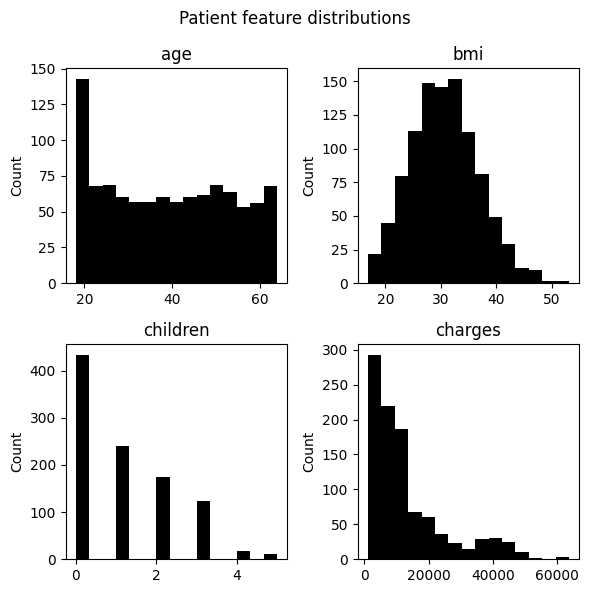

In [9]:
fig, axs=plt.subplots(2,2, figsize=(6,6))
axs=axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(interval_features):
    axs[i].set_title(feature)
    axs[i].hist(training_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

#### 2.2.2. Nominal features

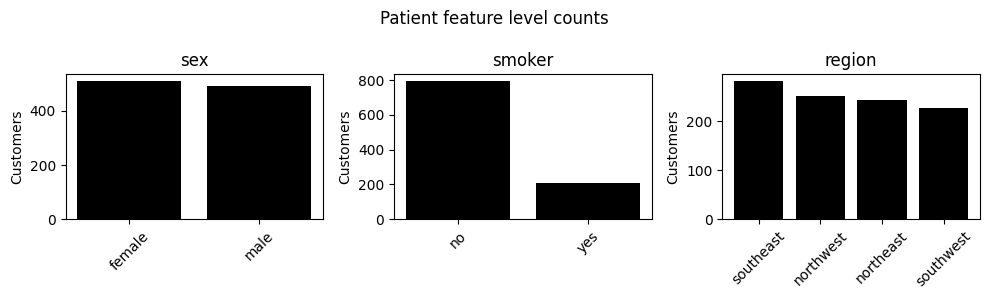

In [10]:
fig, axs=plt.subplots(1,3, figsize=(10,3))
axs=axs.flatten()

fig.suptitle('Patient feature level counts')

for i, feature in enumerate(nominal_features):

    level_counts=training_df[feature].value_counts()

    axs[i].set_title(feature)
    axs[i].bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color='black')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_ylabel('Customers')

fig.tight_layout()
fig.show()

### 2.3. Feature interactions & selection

#### 2.3.1. Interval features vs label

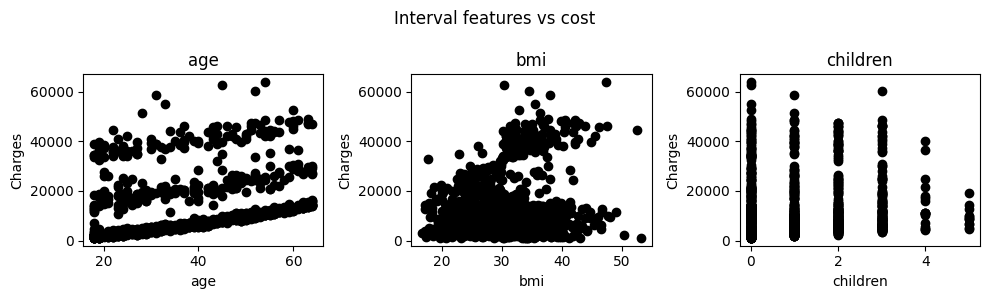

In [11]:
interval_features=['age','bmi','children']

fig, axs=plt.subplots(1,3, figsize=(10,3))
axs=axs.flatten()

fig.suptitle('Interval features vs cost')

for i, feature in enumerate(interval_features):

    level_counts=training_df[feature].value_counts()

    axs[i].set_title(feature)
    axs[i].scatter(training_df[feature], training_df['charges'], color='black')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Charges')

fig.tight_layout()
fig.show()

#### 2.3.1. Nominal features vs label

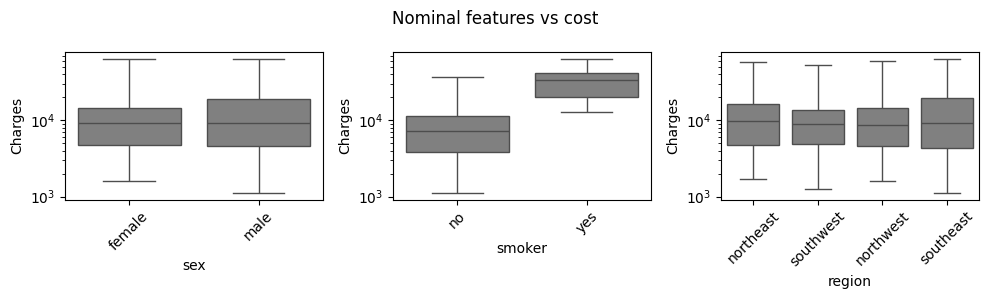

In [12]:
fig, axs=plt.subplots(1,3, figsize=(10,3))
axs=axs.flatten()

fig.suptitle('Nominal features vs cost')

for i, feature in enumerate(nominal_features):

    sns.boxplot(training_df, x=feature, y='charges', color='grey', log_scale=True, ax=axs[i])
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Charges')

plt.tight_layout()
plt.show()

In [13]:
nominal_features=['smoker']

### 2.4. Feature encoding & scaling

#### 2.4.1. Nominal features

In [14]:
encoder=OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(training_df[nominal_features])
encoded_training_features=encoder.transform(training_df[nominal_features])
encoded_testing_features=encoder.transform(testing_df[nominal_features])

encoded_training_features_df=pd.DataFrame(
    encoded_training_features,
    columns=encoder.get_feature_names_out()
)

encoded_testing_features_df=pd.DataFrame(
    encoded_testing_features,
    columns=encoder.get_feature_names_out()
)

encoded_training_features_df.head().transpose()

,0,1,2,3,4
smoker_yes,0.0,1.0,0.0,0.0,0.0


#### 2.4.2. Interval features

In [15]:
standard_scaler=StandardScaler().fit(training_df[interval_features])
scaled_training_features=standard_scaler.transform(training_df[interval_features])
scaled_testing_features=standard_scaler.transform(testing_df[interval_features])

scaled_training_features_df=pd.DataFrame(
    scaled_training_features,
    columns=interval_features
)

scaled_testing_features_df=pd.DataFrame(
    scaled_testing_features,
    columns=interval_features
)

scaled_training_features_df.describe()

,age,bmi,children
count,1.003000e+03,1.003000e+03,1.003000e+03
mean,2.196094e-16,3.595219e-16,1.062626e-17
std,1.000499e+00,1.000499e+00,1.000499e+00
min,-1.497958e+00,-2.233132e+00,-9.064054e-01
25%,-9.291165e-01,-7.016548e-01,-9.064054e-01
50%,-4.749794e-03,-2.780479e-02,-7.387370e-02
75%,8.485118e-01,6.154157e-01,7.586580e-01
max,1.772879e+00,3.621141e+00,3.256253e+00


#### 2.4.3. Final training features

In [16]:
training_features=pd.concat([scaled_training_features_df, encoded_training_features_df], axis=1)
testing_features=pd.concat([scaled_testing_features_df, encoded_testing_features_df], axis=1)
training_features.head()

,age,bmi,children,smoker_yes
0,1.061827,-0.288156,0.758658,0.0
1,1.275143,-0.272841,-0.906405,1.0
2,0.279671,-0.900747,-0.906405,0.0
3,0.066355,-0.526744,-0.073874,0.0
4,-0.715801,-0.558986,-0.906405,0.0


#### 2.4.4. Labels

In [17]:
training_labels=training_df['charges']
testing_labels=testing_df['charges']

label_scaler=StandardScaler().fit(training_df['charges'].values.reshape(-1, 1))
scaled_training_labels=label_scaler.transform(training_df['charges'].values.reshape(-1, 1))
scaled_testing_labels=label_scaler.transform(testing_df['charges'].values.reshape(-1, 1))

## 3. Model training

In [18]:
linear_model=LinearRegression()
linear_model.fit(training_features, scaled_training_labels)
scaled_predictions=linear_model.predict(training_features)
predictions=label_scaler.inverse_transform(scaled_predictions)
rmse=root_mean_squared_error(training_labels, predictions)
print(f'Training data predictions RMSE: ${rmse:.2f}')

Training data predictions RMSE: $6101.68


## 4. Model optimization

### 4.1. Split smoker/nonsmoker model

In [19]:
def prep_data(data_df: pd.DataFrame, nominal_features: list, interval_features: list)-> tuple:
    '''Takes raw data df, runs data preparation pipeline, including train-test split.
    Returns a tuple of training and testing features and labels as well as the label
    scaler for use in unscaling predictions later.'''

    # Do the test-train split
    training_df, testing_df=train_test_split(
        data_df,
        test_size=0.25, 
        random_state=315
    )

    encoder=OneHotEncoder(drop='first', sparse_output=False)
    encoder.fit(training_df[nominal_features])
    encoded_training_features=encoder.transform(training_df[nominal_features])
    encoded_testing_features=encoder.transform(testing_df[nominal_features])

    encoded_training_features_df=pd.DataFrame(
        encoded_training_features,
        columns=encoder.get_feature_names_out()
    )

    encoded_testing_features_df=pd.DataFrame(
        encoded_testing_features,
        columns=encoder.get_feature_names_out()
    )

    standard_scaler=StandardScaler().fit(training_df[interval_features])
    scaled_training_features=standard_scaler.transform(training_df[interval_features])
    scaled_testing_features=standard_scaler.transform(testing_df[interval_features])

    scaled_training_features_df=pd.DataFrame(
        scaled_training_features,
        columns=interval_features
    )

    scaled_testing_features_df=pd.DataFrame(
        scaled_testing_features,
        columns=interval_features
    )

    training_features=pd.concat([scaled_training_features_df, encoded_training_features_df], axis=1)
    testing_features=pd.concat([scaled_testing_features_df, encoded_testing_features_df], axis=1)

    label_scaler=StandardScaler().fit(training_df['charges'].values.reshape(-1, 1))
    scaled_training_labels=label_scaler.transform(training_df['charges'].values.reshape(-1, 1))
    scaled_testing_labels=label_scaler.transform(testing_df['charges'].values.reshape(-1, 1))

    return training_features, testing_features, scaled_training_labels, scaled_testing_labels, label_scaler

In [20]:
nominal_features=[]
interval_features=['age','bmi','children']

smoker_df=data_df[data_df['smoker'] == 'yes'].copy()
smoker_df.drop('smoker', axis=1, inplace=True)

result=prep_data(smoker_df, nominal_features, interval_features)

smoker_training_features=result[0]
smoker_testing_features=result[1]
smoker_scaled_training_labels=result[2]
smoker_scaled_testing_labels=result[3]
smoker_label_scaler=result[4]

nonsmoker_df=data_df[data_df['smoker'] == 'no'].copy()
nonsmoker_df.drop('smoker', axis=1, inplace=True)

result=prep_data(nonsmoker_df, nominal_features, interval_features)

nonsmoker_training_features=result[0]
nonsmoker_testing_features=result[1]
nonsmoker_scaled_training_labels=result[2]
nonsmoker_scaled_testing_labels=result[3]
nonsmoker_label_scaler=result[4]

In [21]:
smoker_model=LinearRegression()
nonsmoker_model=LinearRegression()

smoker_model.fit(smoker_training_features,smoker_scaled_training_labels)
nonsmoker_model.fit(nonsmoker_training_features,nonsmoker_scaled_training_labels)

smoker_scaled_predictions=smoker_model.predict(smoker_training_features)
nonsmoker_scaled_predictions=nonsmoker_model.predict(nonsmoker_training_features)

smoker_predictions=smoker_label_scaler.inverse_transform(smoker_scaled_predictions)
nonsmoker_predictions=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_predictions)

smoker_training_labels=smoker_label_scaler.inverse_transform(smoker_scaled_training_labels)
nonsmoker_training_labels=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_training_labels)

predictions=list(smoker_predictions)+list(nonsmoker_predictions)
labels=list(smoker_training_labels)+list(nonsmoker_training_labels)

rmse=root_mean_squared_error(labels, predictions)
print(f'Split model training RMSE: ${rmse:.2f}')

Split model training RMSE: $4798.46


### 4.2. Evaluation

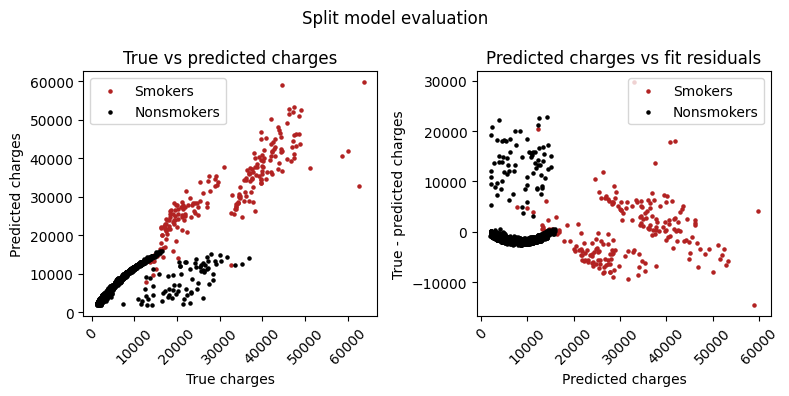

In [22]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Split model evaluation')

axs[0].set_title('True vs predicted charges')
axs[0].scatter(smoker_training_labels, smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[0].scatter(nonsmoker_training_labels, nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel('True charges')
axs[0].set_ylabel('Predicted charges')
axs[0].legend(loc='upper left')

axs[1].set_title('Predicted charges vs fit residuals')
axs[1].scatter(smoker_predictions, smoker_training_labels-smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[1].scatter(nonsmoker_predictions, nonsmoker_training_labels-nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_xlabel('Predicted charges')
axs[1].set_ylabel('True - predicted charges')
axs[1].legend(loc='upper right')

fig.tight_layout()
fig.show()

### 4.3. Data tuning: feature transformations & outlier clipping

In [23]:
nominal_features=[]
interval_features=['age','bmi','children']

smoker_df=data_df[data_df['smoker'] == 'yes'].copy()
smoker_df.drop('smoker', axis=1, inplace=True)
smoker_df['charges']=smoker_df['charges'].clip(upper=50000)

result=prep_data(smoker_df, nominal_features, interval_features)

smoker_training_features=result[0]
smoker_testing_features=result[1]
smoker_scaled_training_labels=result[2]
smoker_scaled_testing_labels=result[3]
smoker_label_scaler=result[4]

nonsmoker_df=data_df[data_df['smoker'] == 'no'].copy()
nonsmoker_df.drop('smoker', axis=1, inplace=True)
nonsmoker_df['charges']=nonsmoker_df['charges'].clip(upper=50000)
nonsmoker_df['age']=nonsmoker_df['age']**2
nonsmoker_df['children']=1/(nonsmoker_df['children']+1)

result=prep_data(nonsmoker_df, nominal_features, interval_features)

nonsmoker_training_features=result[0]
nonsmoker_testing_features=result[1]
nonsmoker_scaled_training_labels=result[2]
nonsmoker_scaled_testing_labels=result[3]
nonsmoker_label_scaler=result[4]

In [24]:
smoker_model=LinearRegression()
nonsmoker_model=LinearRegression()

smoker_model.fit(smoker_training_features,smoker_scaled_training_labels)
nonsmoker_model.fit(nonsmoker_training_features,nonsmoker_scaled_training_labels)

smoker_scaled_predictions=smoker_model.predict(smoker_training_features)
nonsmoker_scaled_predictions=nonsmoker_model.predict(nonsmoker_training_features)

smoker_predictions=smoker_label_scaler.inverse_transform(smoker_scaled_predictions)
nonsmoker_predictions=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_predictions)

smoker_training_labels=smoker_label_scaler.inverse_transform(smoker_scaled_training_labels)
nonsmoker_training_labels=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_training_labels)

predictions=list(smoker_predictions)+list(nonsmoker_predictions)
labels=list(smoker_training_labels)+list(nonsmoker_training_labels)

rmse=root_mean_squared_error(labels, predictions)
print(f'Split model training RMSE: ${rmse:.2f}')

Split model training RMSE: $4643.30


### 4.3. Evaluation

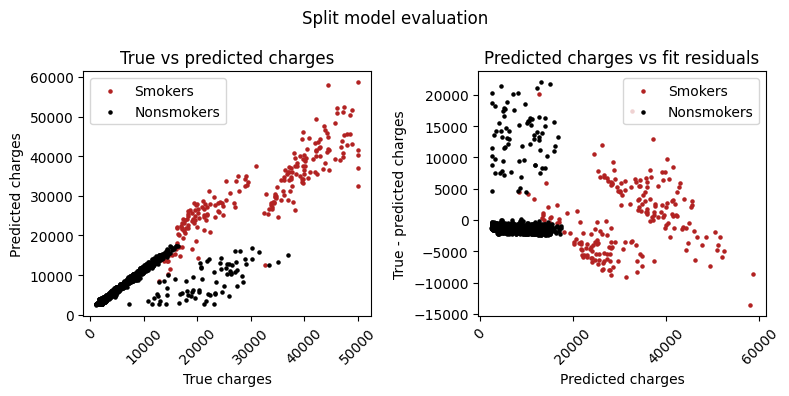

In [25]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Split model evaluation')

axs[0].set_title('True vs predicted charges')
axs[0].scatter(smoker_training_labels, smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[0].scatter(nonsmoker_training_labels, nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_xlabel('True charges')
axs[0].set_ylabel('Predicted charges')
axs[0].legend(loc='upper left')

axs[1].set_title('Predicted charges vs fit residuals')
axs[1].scatter(smoker_predictions, smoker_training_labels-smoker_predictions, color='firebrick', s=5, label='Smokers')
axs[1].scatter(nonsmoker_predictions, nonsmoker_training_labels-nonsmoker_predictions, color='black', s=5, label='Nonsmokers')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_xlabel('Predicted charges')
axs[1].set_ylabel('True - predicted charges')
axs[1].legend(loc='upper right')

fig.tight_layout()
fig.show()

### 4.4. Final model evaluation

In [26]:
smoker_scaled_predictions=smoker_model.predict(smoker_testing_features)
nonsmoker_scaled_predictions=nonsmoker_model.predict(nonsmoker_testing_features)

smoker_predictions=smoker_label_scaler.inverse_transform(smoker_scaled_predictions)
nonsmoker_predictions=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_predictions)

smoker_testing_labels=smoker_label_scaler.inverse_transform(smoker_scaled_testing_labels)
nonsmoker_testing_labels=nonsmoker_label_scaler.inverse_transform(nonsmoker_scaled_testing_labels)

predictions=list(smoker_predictions)+list(nonsmoker_predictions)
labels=list(smoker_testing_labels)+list(nonsmoker_testing_labels)

rmse=root_mean_squared_error(labels, predictions)
print(f'Split model test RMSE: ${rmse:.2f}')

Split model test RMSE: $4934.70
